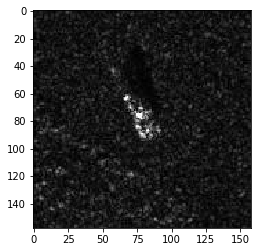

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "train/"

CATEGORIES = ["2S1", "D7"]

for category in CATEGORIES:  
    path = os.path.join(DATADIR,category)  # create path to 2S1 and D7
    for img in os.listdir(path):  # iterate over each image per 2S1 and D7
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [141]:
print(img_array)

[[13 44 33 ... 24 10  9]
 [ 9 22 19 ... 16  5  5]
 [41 25 17 ... 18 11  8]
 ...
 [ 7  9 21 ... 14  8 10]
 [30 15 14 ... 15 11 13]
 [37 17  9 ... 23 25 29]]


In [142]:
print(img_array.shape)

(158, 158)


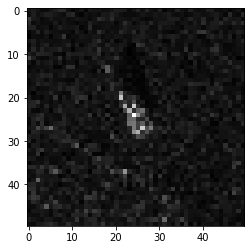

In [143]:
IMG_SIZE = 50

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [144]:
training_data = []
def create_training_data():
    for category in CATEGORIES:  # do 2S1 and D7

        path = os.path.join(DATADIR,category)  # create path to 2S1 and D7
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=2S1 and 1=D7

        for img in tqdm(os.listdir(path)):  # iterate over each image per 2S1 and D7
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|███████████████████████████████████████████████████████████████████████████████| 573/573 [00:00<00:00, 991.54it/s]

1145


In [145]:
import random

random.shuffle(training_data)

In [146]:
for sample in training_data[:10]:
    print(sample[1])

0
1
0
1
1
0
0
1
1
1


In [147]:
X = []
y = []
for features,label in training_data:
    X.append(features)
    y.append(label)
print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

[[[[42]
   [ 3]
   [20]
   ...
   [18]
   [20]
   [42]]

  [[16]
   [20]
   [16]
   ...
   [25]
   [ 8]
   [27]]

  [[21]
   [10]
   [28]
   ...
   [23]
   [ 9]
   [14]]

  ...

  [[19]
   [25]
   [31]
   ...
   [32]
   [15]
   [40]]

  [[ 6]
   [21]
   [19]
   ...
   [24]
   [25]
   [22]]

  [[26]
   [ 7]
   [15]
   ...
   [15]
   [27]
   [35]]]]


In [148]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [149]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [150]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)
X=np.array(X)
y=np.array(y)
X = X/255.0

dense_layers = [0]
layer_sizes = [64]
conv_layers = [3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, y,
                      batch_size=32,
                      epochs=10,
                      validation_split=0.3)
                      #callbacks=[tensorboard])

model.save('64x3-CNN.model')

3-conv-64-nodes-0-dense-1588351223
Train on 801 samples, validate on 344 samples
Epoch 1/10
801/801 [==============================] - 5s 6ms/sample - loss: 0.5184 - accuracy: 0.8127 - val_loss: 0.1627 - val_accuracy: 0.9884
Epoch 2/10
801/801 [==============================] - 4s 5ms/sample - loss: 0.0530 - accuracy: 0.9975 - val_loss: 0.0099 - val_accuracy: 0.9971
Epoch 3/10
801/801 [==============================] - 4s 5ms/sample - loss: 0.0095 - accuracy: 0.9975 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 4/10
801/801 [==============================] - 4s 5ms/sample - loss: 0.0131 - accuracy: 0.9963 - val_loss: 0.1744 - val_accuracy: 0.9302
Epoch 5/10
801/801 [==============================] - 4s 5ms/sample - loss: 0.0691 - accuracy: 0.9775 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 6/10
801/801 [==============================] - 4s 5ms/sample - loss: 0.0065 - accuracy: 0.9988 - val_loss: 0.0066 - val_accuracy: 0.9971
Epoch 7/10
801/801 [==============================] - 4

In [151]:
import cv2
import tensorflow as tf

CATEGORIES = ["2S1","D7"]  # will use this to convert prediction num to string value


def prepare(filepath):
    IMG_SIZE = 50  # 50 in txt-based
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # read in the image, convert to grayscale
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize image to match model's expected sizing
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # return the image with shaping that TF wants.

In [152]:
model = tf.keras.models.load_model("64x3-CNN.model")

In [164]:
prediction = model.predict([prepare('D7.jpeg')])
print(prediction)  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])

[[1.]]
D7


In [156]:
prediction = model.predict([prepare('2S1.jpg')])
print(prediction)  # will be a list in a list.
print(CATEGORIES[int(prediction[0][0])])

[[0.]]
2S1
